# Regressão Linear com Vendas de Pizza

## Importação de Bibliotecas

In [15]:
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

## Seleção

O dataset usado contém informações sobre a venda de pizzas em um supermercado de Belém ao longo de 2023.

Para lidar com os caminhos dos diretórios, usamos a classe `Path` da biblioteca `pathlib`. A leitura do arquivo **CSV** foi feita com a função `read_csv` da biblioteca **pandas**.

In [16]:
DATA_PATH = Path("..") / "data" / "sales_pizza_2023.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,DATE,COUNT
0,2023-01-01,0
1,2023-01-02,148
2,2023-01-03,157
3,2023-01-04,153
4,2023-01-05,134


Para compreender melhor os dados presentes no `DataFrame`, usamos o método `info` para visualizar o número de entradas e colunas, os tipos dos dados e a presença de valores nulos.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    365 non-null    object
 1   COUNT   365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


Observe que o `DataFrame` possui 365 registros, representando cada dia do ano de 2023, 2 colunas e nenhum valor nulo.

## Pré-Processamento

Apesar de não existirem valores nulos no `DataFrame`, usamos a função `fillna` na coluna `COUNT` para preencher valores ausentes com a média da coluna.

In [18]:
df["COUNT"] = df["COUNT"].fillna(df["COUNT"].mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    365 non-null    object
 1   COUNT   365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


Em seguida, tratamos possíveis outliers usando o **Intervalo Interquartil (IQR)**.

In [19]:
q1 = df["COUNT"].quantile(0.25)
q3 = df["COUNT"].quantile(0.75)
iqr = q3 - q1

df = df[(df["COUNT"] > q1 - 1.5 * iqr) & (df["COUNT"] < q3 + 1.5 * iqr)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    363 non-null    object
 1   COUNT   363 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.5+ KB


Antes da remoção dos outliers, o `DataFrame` possuía 365 registros. Após a remoção, restam 363 registros, indicando que 2 outliers foram removidos.

## Transformação

Salvamos o `DataFrame` processado em um arquivo binário usando a biblioteca `pickle`. Isso permite reutilizar os dados sem precisar refazer o pré-processamento.

In [20]:
with Path.open("../data/sales_pizza_2023_processed.pkl", "wb") as f:
    pickle.dump(df, f)

Em seguida, converteremos o tipo da coluna `DATE` de `object` para `datetime64` usando a `to_datetime` da biblioteca **pandas**.

In [21]:
df["DATE"] = pd.to_datetime(df["DATE"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    363 non-null    datetime64[ns]
 1   COUNT   363 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.5 KB


Criamos uma coluna chamada `DAYS` para armazenar a contagem de dias a partir da menor data registrada.

In [22]:
df["DAYS"] = (df["DATE"] - df["DATE"].min()).dt.days
df.head()

,DATE,COUNT,DAYS
0,2023-01-01,0,0
1,2023-01-02,148,1
2,2023-01-03,157,2
3,2023-01-04,153,3
4,2023-01-05,134,4


## Mineração de Dados

Inicialmente, usamos a classe `LinearRegression` da biblioteca **scikit-learn**, que realiza o ajuste de uma reta aos dados de forma automática através do método `fit`.

In [23]:
model = LinearRegression()
model.fit(df[["DAYS"]], df["COUNT"])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Também usamos a classe `ManualLinearRegression`, que realiza o ajuste de uma reta aos dados de forma manual através do método `fit`.

In [24]:
class ManualLinearRegression:
    def __init__(self) -> None:
        self.slope = 0
        self.intercept = 0

    def fit(self, x_values: pd.Series, y_values: pd.Series) -> None:
        best_sum = float("inf")

        slope_range = [i * 0.1 for i in range(-50, 50)]
        intercept_range = range(y_values.min(), y_values.max())

        for a in slope_range:
            for b in intercept_range:
                absolute_residuals = []

                for x, y in zip(x_values, y_values, strict=True):
                    absolute_residuals.append((((a * x + b) - y) ** 2) ** (1/2))

                sum_of_absolute_residuals = sum(absolute_residuals)

                if sum_of_absolute_residuals < best_sum:
                    self.slope = a
                    self.intercept = b
                    best_sum = sum_of_absolute_residuals

    def predict(self, x_values: pd.Series) -> list:
        return [self.slope * x + self.intercept for x in x_values]


manual_model = ManualLinearRegression()
manual_model.fit(df["DAYS"], df["COUNT"])

Após o ajuste, usamos ambos os modelos para prever a quantidade de vendas.

In [25]:
predicted_values_sklearn = model.predict(df[["DAYS"]])
predicted_values_manual = manual_model.predict(df["DAYS"])

## Avaliação

Criamos gráficos de dispersão para os valores observados e sobrepomos as retas ajustadas pelos dois modelos.

In [26]:
results_path = Path("..") / "results"

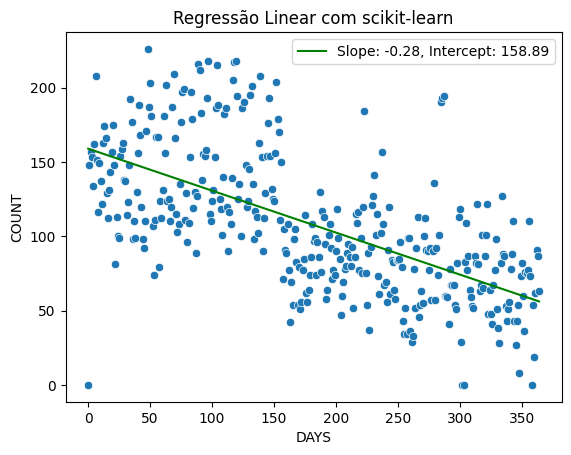

In [27]:
sns.scatterplot(df, x="DAYS", y="COUNT")
sklearn_line, = plt.plot(df["DAYS"], predicted_values_sklearn, c="green")
txt_sklearn =  f"Slope: {model.coef_[0]:.2f}, Intercept: {model.intercept_:.2f}"
plt.legend([sklearn_line], [txt_sklearn])
plt.title("Regressão Linear com scikit-learn")
plt.savefig(results_path / "regressao_sklearn.png")
plt.show()

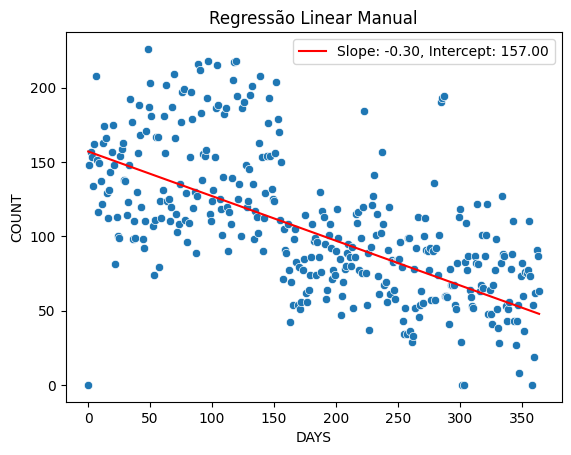

In [28]:
sns.scatterplot(df, x="DAYS", y="COUNT")
manual_line, = plt.plot(df["DAYS"], predicted_values_manual, c="red")
txt_manual = f"Slope: {manual_model.slope:.2f}, Intercept: {manual_model.intercept:.2f}"
plt.legend([manual_line], [txt_manual])
plt.title("Regressão Linear Manual")
plt.savefig(results_path / "regressao_manual.png")
plt.show()